# Analyzing Winning factors on Premier League

Author:Zheyu Wu

Course Project, UC Irvine, Math 10, S23

## Introduction

![Picture title](image-20230610-213402.png)

The English Premier League (EPL) is globally renowned as one of the most popular football leagues. It consists of 20 teams competing in a total of 38 matches over a year. The team with the highest points will be the winner. In this system, a win earns a team 3 points, a draw results in 1 point each for both teams, and a loss yields zero points. Each team faces every other team in the league once at home and once as the away team.
For this project, I want to investigate which factors will contribute the most for winning a match in the Premier League.

## Importing and Cleaning the Data

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
import seaborn as sns

In [2]:
df = pd.read_csv('stats.csv')
df

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches,season
0,Manchester United,28.0,5.0,83.0,60.0,1.0,698.0,256.0,21.0,12.0,...,918.0,258.0,25686.0,NaN,1.0,NaN,2.0,37.0,25.0,2006-2007
1,Chelsea,24.0,3.0,64.0,62.0,4.0,636.0,216.0,14.0,16.0,...,897.0,231.0,24010.0,NaN,2.0,NaN,1.0,74.0,22.0,2006-2007
2,Liverpool,20.0,10.0,57.0,44.0,0.0,668.0,214.0,15.0,8.0,...,1107.0,282.0,24150.0,NaN,1.0,NaN,0.0,51.0,27.0,2006-2007
3,Arsenal,19.0,8.0,63.0,59.0,3.0,638.0,226.0,19.0,10.0,...,873.0,278.0,25592.0,NaN,1.0,NaN,0.0,88.0,27.0,2006-2007
4,Tottenham Hotspur,17.0,12.0,57.0,48.0,3.0,520.0,184.0,6.0,5.0,...,796.0,181.0,22200.0,NaN,2.0,NaN,0.0,51.0,24.0,2006-2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Huddersfield Town,9.0,19.0,28.0,62.0,3.0,362.0,109.0,8.0,5.0,...,765.0,165.0,22619.0,21.0,6.0,416.0,2.0,31.0,24.0,2017-2018
236,Swansea City,8.0,21.0,28.0,51.0,1.0,338.0,103.0,8.0,3.0,...,694.0,150.0,22775.0,26.0,1.0,439.0,3.0,44.0,15.0,2017-2018
237,Southampton,7.0,16.0,37.0,63.0,2.0,450.0,145.0,15.0,7.0,...,800.0,227.0,24639.0,37.0,4.0,379.0,1.0,29.0,13.0,2017-2018
238,Stoke City,7.0,19.0,35.0,62.0,1.0,384.0,132.0,8.0,8.0,...,598.0,136.0,20368.0,33.0,3.0,402.0,0.0,27.0,14.0,2017-2018


In [3]:
#check for missing values
df.isnull().values.any()

True

In [4]:
#drop the missing values
df = df.dropna(axis=0).copy()

In [5]:
df.shape

(160, 42)

In order to keep my data to be general on analyzing Premier League teams, I decide to analyze those teams which can stay for at least three seasons since for those relatively weaker teams, they are probably not on the same levels compares to other Premier League teams.

In [6]:
team_seasons = df.groupby('team')['season'].nunique().reset_index()
filtered_teams = team_seasons[team_seasons['season'] >= 3]['team']
df = df[df['team'].isin(filtered_teams)]

After cleaning my dataset, I want to check the average data and then I can have a rough thoughts about which factors I should predict to have a positve/negative impact to win.

In [7]:
df_avg = df.groupby(['team'],as_index=False).mean()
df_avg.sort_values(by='wins',ascending=False).head(3)

,team,wins,losses,goals,total_yel_card,total_red_card,total_scoring_att,ontarget_scoring_att,hit_woodwork,att_hd_goal,...,backward_pass,total_cross,corner_taken,touches,big_chance_missed,clearance_off_line,dispossessed,penalty_save,total_high_claim,punches
11,Manchester City,24.625,6.375,82.625,65.500,2.750,650.00,227.000,18.500,8.500,...,3179.500,813.75,267.625,29239.875,58.000,3.125,487.375,1.000,41.750,26.125
12,Manchester United,22.500,7.000,68.750,62.625,2.125,549.50,195.375,15.875,12.000,...,2941.750,910.00,229.375,27705.625,47.500,3.125,461.500,0.375,33.250,14.250
4,Chelsea,21.875,7.750,69.875,60.750,3.000,626.25,214.500,14.250,10.875,...,2889.875,812.00,239.000,27226.375,43.625,4.000,463.750,0.250,55.125,19.250


So, there is a roughly thinking that "attacking" data should have a positive impact and "defending" data should be otherwise.

In [8]:
df_avg.corr()["wins"]

wins                    1.000000
losses                 -0.968590
goals                   0.968633
total_yel_card         -0.257762
total_red_card         -0.180572
total_scoring_att       0.833338
ontarget_scoring_att    0.900001
hit_woodwork            0.718569
att_hd_goal             0.502109
att_pen_goal            0.645460
att_freekick_goal       0.349527
att_ibox_goal           0.967825
att_obox_goal           0.681283
goal_fastbreak          0.643157
total_offside           0.211573
clean_sheet             0.930604
goals_conceded         -0.917405
saves                  -0.205303
outfielder_block       -0.768150
interception           -0.210378
total_tackle            0.087433
last_man_tackle         0.131081
total_clearance        -0.614563
head_clearance         -0.377820
own_goals              -0.470851
penalty_conceded       -0.554425
pen_goals_conceded     -0.531732
total_pass              0.841452
total_through_ball      0.776743
total_long_balls       -0.413157
backward_p

## Altair Chart to Visualize the Correlation

In [9]:
selected_columns = [col for col in df.columns if col not in ['wins', 'season','team','losses']]

From [Worksheet7](https://deepnote.com/workspace/zheyu-0ab018e9-04cc-439a-a2c2-90b651fd1424/project/Worksheet-7-Duplicate-8fd1453c-88f3-4839-8c58-d1df36d1ac67/notebook/Worksheet7-328657a7cb814b0190f6481267d5ed24), I learned a way to draw an altair chart which contains different charts with different columns' names splits in columns, and it is a way that clearly shows the correlation with the selected_columns and wins in graph.

In [10]:
def make_chart(c):
    chart = alt.Chart(df_avg).mark_circle().encode(
        x = "wins",
        y = c,
        color = alt.Color("team", scale=alt.Scale(scheme="darkblue")),
        tooltip = ["team","wins"]
    )
    return chart

In [11]:
chart_list = [make_chart(c) for c in selected_columns]
total_chart = alt.vconcat(*chart_list)
total_chart

alt.VConcatChart(...)

## Factor Importance Contribute to Wins

I will use Random Forest to analyze the feature importance to wins in Premier League

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_avg[selected_columns], df_avg['wins'], test_size=0.3, random_state=22)

I used ChatGPT to find a code that could decide how many leaf nodes number I should take, and based on [this twitter](https://twitter.com/daniela_witten/status/1292293102103748609?s=20), I can choose an appropriate number to predict my data.

In [13]:
df_err = pd.DataFrame(columns=['leaves', 'error', 'set'])

for i in range(2, 41):
    regressor = RandomForestRegressor(n_estimators=100, max_leaf_nodes=i, random_state=42)
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    train_error = mean_squared_error(y_train, y_train_pred)
    
    y_test_pred = regressor.predict(X_test)
    test_error = mean_squared_error(y_test, y_test_pred)
    
    df_err.loc[len(df_err)] = {'leaves': i, 'error': train_error, 'set': 'train'}
    df_err.loc[len(df_err)] = {'leaves': i, 'error': test_error, 'set': 'test'}

print(df_err)
c = alt.Chart(df_err).mark_line().encode(
    x='leaves',
    y='error',
    color='set'
)
c

   leaves     error    set
0       2  3.399707  train
1       2  2.408625   test
2       3  1.794364  train
3       3  2.094462   test
4       4  1.110214  train
..    ...       ...    ...
73     38  2.098586   test
74     39  0.678814  train
75     39  2.098586   test
76     40  0.678814  train
77     40  2.098586   test

[78 rows x 3 columns]


alt.Chart(...)

The best choice of max_leaf_nodes should be 5

In [14]:
rfr = RandomForestRegressor(n_estimators=1000, max_leaf_nodes=5,random_state=42)
rfr.fit(X_train,y_train)

RandomForestRegressor(max_leaf_nodes=5, n_estimators=1000, random_state=42)

In [15]:
rfr.score(X_train,y_train)

0.9724047981641236

In [16]:
rfr.score(X_test,y_test)

0.848250967199523

In [17]:
pd.Series(rfr.feature_importances_, index=selected_columns).sort_values(ascending=False)

outfielder_block        0.090093
goals_conceded          0.086272
goals                   0.065844
total_scoring_att       0.065017
total_through_ball      0.062856
backward_pass           0.059776
att_ibox_goal           0.059725
ontarget_scoring_att    0.059307
clean_sheet             0.057036
att_obox_goal           0.048713
big_chance_missed       0.048022
total_pass              0.042571
touches                 0.041945
corner_taken            0.033134
clearance_off_line      0.029099
hit_woodwork            0.025168
att_freekick_goal       0.022858
att_pen_goal            0.018243
goal_fastbreak          0.016872
penalty_conceded        0.009769
total_clearance         0.006979
own_goals               0.006838
penalty_save            0.005824
pen_goals_conceded      0.005630
total_high_claim        0.005070
dispossessed            0.004506
total_tackle            0.003362
att_hd_goal             0.003285
total_yel_card          0.002817
total_offside           0.002622
intercepti

We can see that "outfielder_block" and "goals_conceded" have the most feature importance to wins. Both stats are defending stats. Thus, from Random Forest model, it shows that defending is the key to win.

## LinearRegression Model

In [18]:
lin = LinearRegression()
lin.fit(df_avg[selected_columns],df_avg['wins'])

LinearRegression()

In [19]:
pd.Series(lin.coef_, index=lin.feature_names_in_)

goals                   0.170069
total_yel_card         -0.008121
total_red_card         -0.067695
total_scoring_att      -0.004115
ontarget_scoring_att    0.085436
hit_woodwork           -0.033554
att_hd_goal            -0.023789
att_pen_goal           -0.039289
att_freekick_goal      -0.021382
att_ibox_goal           0.062600
att_obox_goal           0.124503
goal_fastbreak          0.091819
total_offside          -0.031666
clean_sheet             0.089106
goals_conceded         -0.122839
saves                   0.015306
outfielder_block       -0.078234
interception            0.001499
total_tackle           -0.003998
last_man_tackle         0.161247
total_clearance        -0.005070
head_clearance          0.022121
own_goals               0.013613
penalty_conceded        0.032624
pen_goals_conceded      0.075956
total_pass              0.001883
total_through_ball     -0.028828
total_long_balls       -0.001374
backward_pass          -0.002561
total_cross             0.002376
corner_tak

The results shows that "goals" infulence wins the most in positive way and espeically for "att_ibox_goal"(goals inside the penalty area),"goal_fastbreak"(goals from counter attack) and "att_obox_goal"(goals outside the penalty area). The "goals_conceded" shows a negative impact on wins and it is reasonable since it shows the defending level of a team. The coefficients that is unexpected for me is that "passing" inputs are not that significant to determine the wins.

## Passing Visualizing Map

After finding those key inputs contribute to wins, I am very curious about the passing inputs. Because we can see that the total_pass is contributing a positive effect to wins but the others except for total_cross did otherwise. So I want to go further on this topic by drawing the [Passing Plot](https://mplsoccer.readthedocs.io/en/latest/gallery/pitch_plots/plot_arrows.html#sphx-glr-gallery-pitch-plots-plot-arrows-py) on the pitch below.

In [20]:
# From here I choose KDB from Man City vs TOT to see what a top midfielder's passes looks like
df2 = pd.read_csv('KDBpasses.csv')

In [21]:
df2

,player,minute,second,x,y,type,outcome,endX,endY
0,KDB,45,0,50,50,Pass,Successful,40,43
1,KDB,45,25,63,48,Pass,Successful,75,83
2,KDB,46,4,74,58,Pass,Successful,71,65
3,KDB,46,7,76,68,Pass,Successful,95,78
4,KDB,46,55,100,1,Pass,Unsuccessful,96,38
5,KDB,47,42,73,25,Pass,Successful,70,54
6,KDB,49,47,75,43,Pass,Unsuccessful,82,38
7,KDB,50,10,79,31,Pass,Successful,87,24
8,KDB,50,17,82,52,Pass,Successful,93,68
9,KDB,50,24,98,62,Pass,Unsuccessful,98,61


In [22]:
#Converting our data to fit the football map
df2['x'] = df2['x']*1.2
df2['y'] = df2['y']*0.8
df2['endX'] = df2['endX']*1.2
df2['endY'] = df2['endY']*0.8
df2

,player,minute,second,x,y,type,outcome,endX,endY
0,KDB,45,0,60.0,40.0,Pass,Successful,48.0,34.4
1,KDB,45,25,75.6,38.4,Pass,Successful,90.0,66.4
2,KDB,46,4,88.8,46.4,Pass,Successful,85.2,52.0
3,KDB,46,7,91.2,54.4,Pass,Successful,114.0,62.4
4,KDB,46,55,120.0,0.8,Pass,Unsuccessful,115.2,30.4
5,KDB,47,42,87.6,20.0,Pass,Successful,84.0,43.2
6,KDB,49,47,90.0,34.4,Pass,Unsuccessful,98.4,30.4
7,KDB,50,10,94.8,24.8,Pass,Successful,104.4,19.2
8,KDB,50,17,98.4,41.6,Pass,Successful,111.6,54.4
9,KDB,50,24,117.6,49.6,Pass,Unsuccessful,117.6,48.8


Text(0.5, 1.0, 'KDB Pass Map vs TOT')

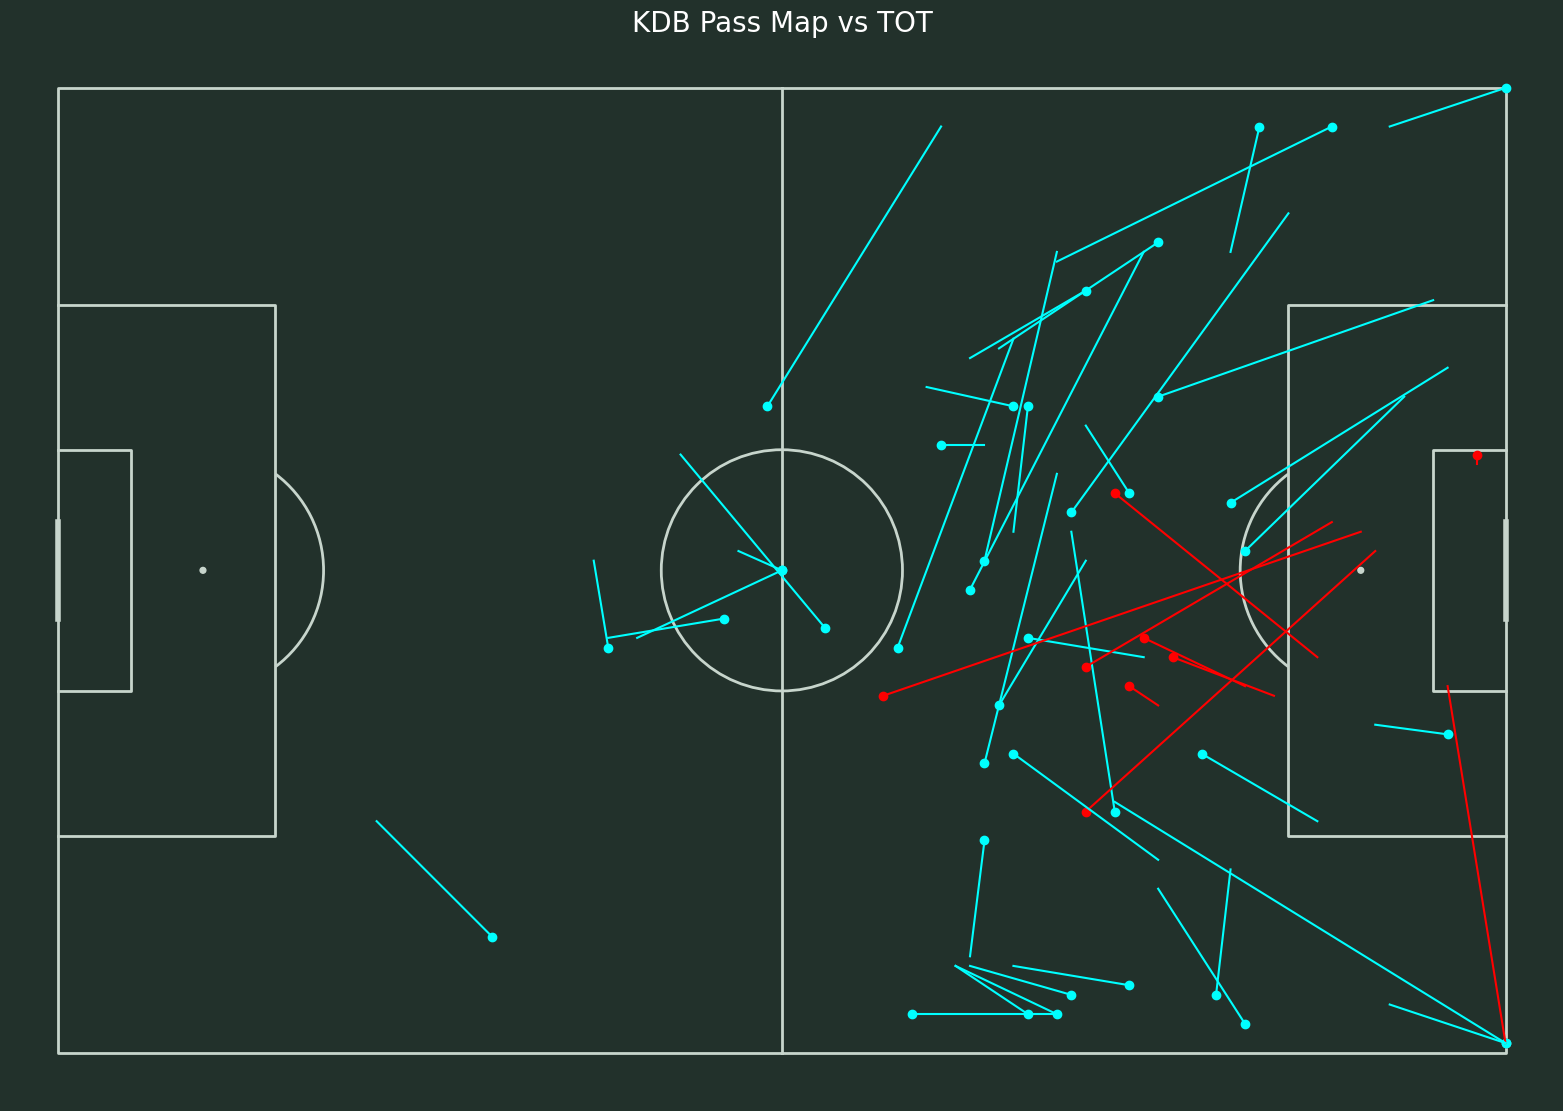

In [23]:
# draw the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
plt.gca().invert_yaxis()

for x in range(len(df2['x'])):
    if df2['outcome'][x] == 'Successful':
        plt.plot((df2['x'][x],df2['endX'][x]),(df2['y'][x],df2['endY'][x]),color='cyan')
        plt.scatter(df2['x'][x],df2['y'][x],color='cyan')
        # Successful passes are in color cyan
    if df2['outcome'][x] == 'Unsuccessful':
        plt.plot((df2['x'][x],df2['endX'][x]),(df2['y'][x],df2['endY'][x]),color='red')
        plt.scatter(df2['x'][x],df2['y'][x],color='red')
        # Unsuccessful passes are in color red

plt.title('KDB Pass Map vs TOT',color='white',size=20)

From here, we can find that most of successful passes are backward passes which are less likely to affect a goal, while about half of the passes are forward passes that are close to the box. Therefore, from here we can say that those forward passes have more impact to score a goal which contribute the most as an attack input to win. After doing some researches, these passes are called [Progressive Paases](https://www.americansocceranalysis.com/home/2021/2/25/where-goals-come-from-the-five-progressive-passes). Therefore, I need to clarrified those progressive passes by following this [Tutorial](https://www.youtube.com/watch?v=kuD1yMwjCwE)

In [24]:
# see the passing distance to determine which passes are progressive pass.
df2['beginning'] = np.sqrt(np.square(120-df2['x'])+np.square(40-df2['y']))
df2['end'] = np.sqrt(np.square(120 - df2['endX'])+np.square(40-df2['endY']))
df2['progressive'] = [(df2['end'][x]) / (df2['beginning'][x]) < .75 for x in range(len(df2.beginning))]
df2.head()

,player,minute,second,x,y,type,outcome,endX,endY,beginning,end,progressive
0,KDB,45,0,60.0,40.0,Pass,Successful,48.0,34.4,60.000000,72.217449,False
1,KDB,45,25,75.6,38.4,Pass,Successful,90.0,66.4,44.428819,39.961982,False
2,KDB,46,4,88.8,46.4,Pass,Successful,85.2,52.0,31.849647,36.810868,False
3,KDB,46,7,91.2,54.4,Pass,Successful,114.0,62.4,32.199379,23.189653,True
4,KDB,46,55,120.0,0.8,Pass,Unsuccessful,115.2,30.4,39.200000,10.733126,True


In [25]:
df3 = df2.loc[df2['progressive'] == True]
df3

,player,minute,second,x,y,type,outcome,endX,endY,beginning,end,progressive
3,KDB,46,7,91.2,54.4,Pass,Successful,114.0,62.4,32.199379,23.189653,True
4,KDB,46,55,120.0,0.8,Pass,Unsuccessful,115.2,30.4,39.200000,10.733126,True
23,KDB,67,40,87.6,46.4,Pass,Unsuccessful,104.4,32.8,33.026050,17.181385,True
27,KDB,71,46,97.2,45.6,Pass,Successful,115.2,56.8,23.477649,17.472264,True
42,KDB,83,14,85.2,32.0,Pass,Unsuccessful,105.6,44.0,35.707702,14.945233,True
45,KDB,90,18,85.2,20.0,Pass,Unsuccessful,109.2,41.6,40.137763,10.917875,True
48,KDB,94,7,68.4,29.6,Pass,Unsuccessful,108.0,43.2,52.637629,12.419340,True


As we can see, most the progressive passes that Kevin did are **unsuccessful** in the second half of this match.

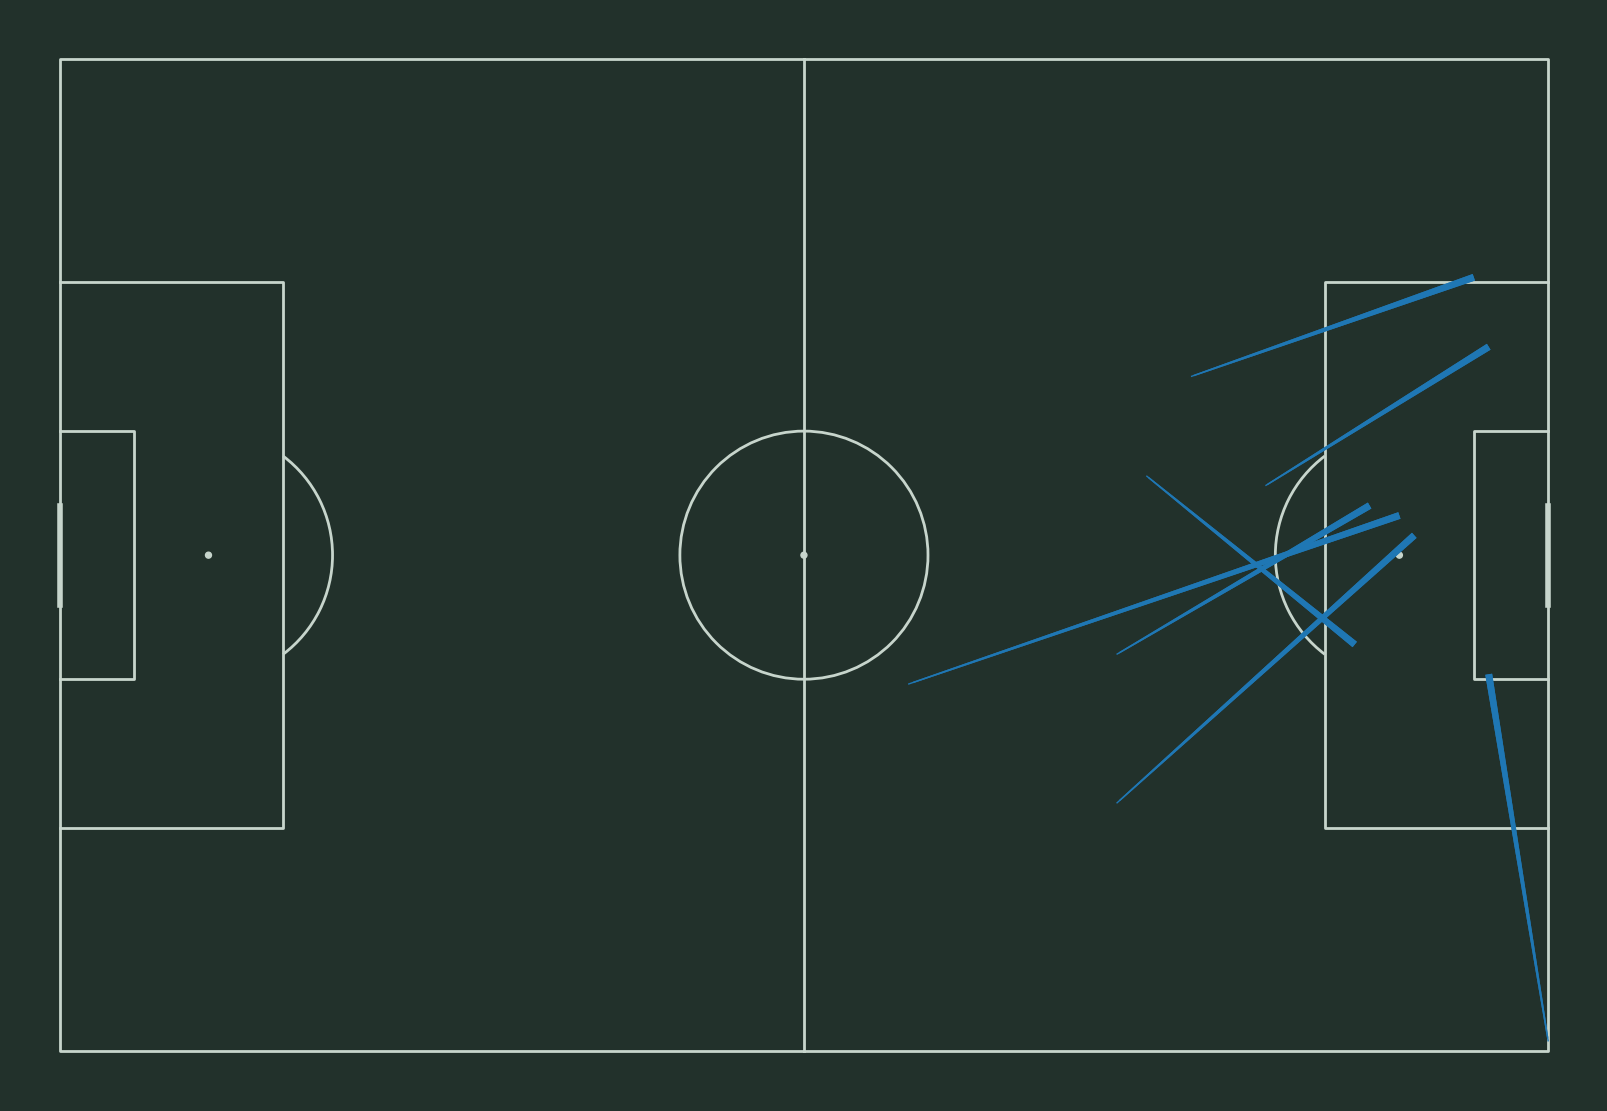

In [31]:
# Visualizing the progressive passes made by KDB
pitch = Pitch(pitch_type='statsbomb',pitch_color='#22312b', line_color='#c7d5cc')
fig,ax = pitch.draw(figsize=(16, 11), constrained_layout=True, tight_layout=False)
fig.set_facecolor('#22312b')
plt.gca().invert_yaxis()

pitch.lines(df3.x,df3.y,df3.endX,df3.endY,comet=True,ax=ax,)

Therefore, not all passes are creating chances to score goals. Only progressive passes (like crossing) are the "key" passes. That's why passes like backward passes have a negative impact on winning a match, since it has an opposite relation with goals.

## Summary

Overall, this project I did are basically analyzing the important facotrs contributing to win a match in Premier League. Scoring a goal is the key attacking input for winning. outfielder_block and goals_conceded are the key defending inputs for winning.

## References

Your code above should include references.  Here is some additional space for references.

* What is the source of your dataset(s)?

[Data](https://www.kaggle.com/datasets/zaeemnalla/premier-league?select=stats.csv)

* List any other references that you found helpful.

[Prgressive Pass Def](https://www.stlcitysc.com/news/soccer-stats-explained-progressive-passing)
[Create a soccer pitch](https://www.youtube.com/watch?v=55k1mCRyd2k)

## Submission

Using the Share button at the top right, **enable Comment privileges** for anyone with a link to the project. Then submit that link on Canvas.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c163aa9f-e454-4344-b4d7-80ed3f1e3d79' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>